<a href="https://colab.research.google.com/github/IbrahimMauki/Learning_github/blob/main/PPI_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython
!pip install ipywidgets --upgrade

!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension

!jupyter labextension install @jupyter-widgets/jupyterlab-manager


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /usr/local/lib/python3.12/dist-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /usr/local/share/jupyter/nbextensions/

## 🧬 GenBank Downloader Script

This script allows users to download GenBank records from NCBI using a valid nucleotide accession number (e.g., `NC_003198.1`, `CP000034.1`). It is designed for reproducibility and ease of use in shared environments like Google Colab.

### 🔹 Features
- Prompts user for email (required by NCBI Entrez) and validates format.
- Accepts standard nucleotide accession formats.
- Saves the GenBank record as a `.gbk` file with a user-defined filename.

### 🔹 Notes
- Only works with **nucleotide accessions** (e.g., NC_, CP_, AY_). Does **not** support GCF_ or GCA_ assembly IDs.
- Uses `gbwithparts` format to include full annotations and features.
- Designed for single-record downloads; batch support can be added later.

### 🔹 Example Usage
```text
Enter your email: user@example.com
Enter accession: NC_003198.1
Output filename: salmonella
```
This will save the GenBank record as salmonella.gbk


In [2]:

from Bio import Entrez
import re

def download_genbank():
    Entrez.email = input("Enter your email: ").strip()
    acc = input("Enter accession (e.g., NC_003198.1 or CP000034.1): ").strip()
    filename = input("Output filename (no extension): ").strip() + ".gbk"

    # ✅ Updated regex: allows NC_003198.1 and CP000034.1
    if not re.match(r"^[A-Z]{2,4}[0-9_]+\.[0-9]+$", acc):
        print("❌ Invalid accession format."); return
    if not re.match(r"[^@]+@[^@]+\.[^@]+", Entrez.email):
        print("❌ Invalid email."); return

    print("⏳ Downloading...")
    try:
        with Entrez.efetch(db="nucleotide", id=acc, rettype="gbwithparts", retmode="text") as handle:
            content = handle.read()

        if "Error:" in content or "failed" in content.lower():
            print("❌ NCBI returned an error. Accession may be invalid or unsupported.")
            return

        with open(filename, "w") as f:
            f.write(content)

        print(f"✔ Saved as: {filename}")

    except Exception as e:
        print(f"❌ Download failed: {e}")

download_genbank()

Enter your email: maukyibrahim@gmail.com
Enter accession (e.g., NC_003198.1 or CP000034.1): NC_003198.1
Output filename (no extension): salmonella
⏳ Downloading...
✔ Saved as: salmonella.gbk


## 🧬 Extract and Annotate Protein-Coding Genes (CDS)

This step parses the GenBank file generated earlier to extract annotated protein-coding genes (CDS features). Each CDS is annotated with:

- **Gene name**
- **Product description**
- **Locus tag**
- **Protein ID**
- **DNA sequence**
- **Translated protein sequence**

### 🔹 Input
- GenBank file (`.gbk`) from previous step, e.g. `salmonella.gbk`

### 🔹 Output
- A pandas DataFrame containing annotated CDS entries
- Ready for export, filtering, or downstream analysis (e.g. BLAST, functional annotation)

### 🔹 Notes
- Missing annotations are filled with `"NA"` to preserve structure
- Translation field may be absent for pseudogenes or incomplete entries

In [3]:
from Bio import SeqIO
import pandas as pd
import os

# === Prompt for GenBank file ===
gbk_file = input("Enter GenBank filename (e.g., salmonella.gbk): ").strip()

# === Check if file exists ===
if not os.path.isfile(gbk_file):
    print(f"❌ ERROR: File '{gbk_file}' not found. Please check the filename and try again.")
else:
    cds_data = []

    for record in SeqIO.parse(gbk_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                q = feature.qualifiers
                cds_data.append({
                    "Gene": q.get("gene", ["NA"])[0],
                    "Product": q.get("product", ["NA"])[0],
                    "Locus Tag": q.get("locus_tag", ["NA"])[0],
                    "Protein ID": q.get("protein_id", ["NA"])[0],
                    "DNA Sequence": str(feature.location.extract(record).seq),
                    "Protein Sequence": q.get("translation", ["NA"])[0]
                })

    # === Convert to DataFrame ===
    cds_df = pd.DataFrame(cds_data)
    print("✔ CDS features extracted:")
    print(cds_df.head())

Enter GenBank filename (e.g., salmonella.gbk): salmonella.gbk
✔ CDS features extracted:
   Gene                                            Product    Locus Tag  \
0  thrL                          thr operon leader peptide  STY_RS00005   
1  thrA  bifunctional aspartate kinase/homoserine dehyd...  STY_RS00010   
2  thrB                                  homoserine kinase  STY_RS00015   
3  thrC                                 threonine synthase  STY_RS00020   
4  yaaA                       peroxide stress protein YaaA  STY_RS00025   

       Protein ID                                       DNA Sequence  \
0  WP_001575544.1  ATGAACCGCATCAGCACCACCACCATTACCACCATCACCATTACCA...   
1  WP_001264731.1  ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...   
2  WP_000241685.1  ATGGTGAAAGTGTATGCCCCGGCTTCCAGCGCGAACATGAGCGTCG...   
3  WP_000781103.1  ATGAAACTCTATAATCTGAAAGACCATAATGAGCAGGTCAGCTTTG...   
4  WP_000906171.1  ATGCTGATTCTGATTTCACCTGCAAAAACGCTTGATTATCAAAGCC...   

                            

## 🧬 Convert Extracted CDS Data to a Pandas DataFrame

This step transforms the list of extracted CDS annotations into a structured pandas DataFrame for easy preview, filtering, and downstream analysis.

### 🔹 Input
- `cds_data`: A list of dictionaries containing gene name, product, locus tag, protein ID, DNA sequence, and protein sequence.

### 🔹 Output
- `cds_df`: A pandas DataFrame with one row per CDS feature.
- Displays the first few rows using `.head()` to verify successful parsing and structure.

### 🔹 Notes
- This DataFrame can be exported to CSV or integrated into SQLite for further querying.
- Missing annotations are represented as `"NA"` to maintain column consistency.

In [4]:
import pandas as pd

# === Convert extracted CDS data to DataFrame ===
cds_df = pd.DataFrame(cds_data)

# === Preview the first few entries ===
print("✔ Preview of extracted CDS annotations:")
cds_df.head()

✔ Preview of extracted CDS annotations:


,Gene,Product,Locus Tag,Protein ID,DNA Sequence,Protein Sequence
0,thrL,thr operon leader peptide,STY_RS00005,WP_001575544.1,ATGAACCGCATCAGCACCACCACCATTACCACCATCACCATTACCA...,MNRISTTTITTITITTGNGAG
1,thrA,bifunctional aspartate kinase/homoserine dehyd...,STY_RS00010,WP_001264731.1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNSRQGQVATVLSAPAKITNH...
2,thrB,homoserine kinase,STY_RS00015,WP_000241685.1,ATGGTGAAAGTGTATGCCCCGGCTTCCAGCGCGAACATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGTLLGDVVSVEAADHFRL...
3,thrC,threonine synthase,STY_RS00020,WP_000781103.1,ATGAAACTCTATAATCTGAAAGACCATAATGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKQQGLFFPHDLPEFSLTEIDEM...
4,yaaA,peroxide stress protein YaaA,STY_RS00025,WP_000906171.1,ATGCTGATTCTGATTTCACCTGCAAAAACGCTTGATTATCAAAGCC...,MLILISPAKTLDYQSPLATTRYTQPELLDHSQQLIQQARQLSAPQI...


## 🧬 Create SQLite Database and Insert Gene Data

This step stores annotated CDS features in a local SQLite database for structured querying and downstream integration.

### 🔹 Input
- `cds_df`: DataFrame containing extracted and annotated CDS features.

### 🔹 Process
1. Connect to (or create) a SQLite database named `pathogen_sequences.db`.
2. Create a table `gene_protein_data` with fields for gene name, product, locus tag, protein ID, DNA sequence, and protein sequence.
3. Clear old records to avoid duplication.
4. Filter out entries with missing or `"NA"` protein IDs.
5. Insert valid records into the database.
6. Preview the number of inserted records and sample entries.

### 🔹 Output
- A populated SQLite table ready for querying, enrichment, or export.

### 🔹 Notes
- This step ensures reproducibility and modularity by storing gene annotations in a structured format.
- Can be extended to support multiple species or strains by adding a `species` or `source_file` column.

In [5]:
import sqlite3

# === Connect to SQLite database ===
db_name = "pathogen_sequences.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# === Create table for gene annotations ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS gene_protein_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    gene_name TEXT,
    product TEXT,
    locus_tag TEXT,
    protein_id TEXT,
    dna_sequence TEXT,
    protein_sequence TEXT
)
""")
conn.commit()

# === Clear old records ===
cursor.execute("DELETE FROM gene_protein_data")
conn.commit()

# === Filter valid entries before insertion ===
filtered_df = cds_df[
    cds_df["Protein ID"].notna() &
    (cds_df["Protein ID"].str.upper() != "NA")
]

# === Insert into database ===
for _, row in filtered_df.iterrows():
    cursor.execute("""
    INSERT INTO gene_protein_data (
        gene_name, product, locus_tag, protein_id, dna_sequence, protein_sequence
    ) VALUES (?, ?, ?, ?, ?, ?)
    """, (
        row["Gene"],
        row["Product"],
        row["Locus Tag"],
        row["Protein ID"],
        row["DNA Sequence"],
        row["Protein Sequence"]
    ))
conn.commit()

# === Verify and preview ===
cursor.execute("SELECT COUNT(*) FROM gene_protein_data")
print("✔ Total records inserted:", cursor.fetchone()[0])

cursor.execute("SELECT protein_id, product FROM gene_protein_data LIMIT 25")
for row in cursor.fetchall():
    print(row)

✔ Total records inserted: 4330
('WP_001575544.1', 'thr operon leader peptide')
('WP_001264731.1', 'bifunctional aspartate kinase/homoserine dehydrogenase I')
('WP_000241685.1', 'homoserine kinase')
('WP_000781103.1', 'threonine synthase')
('WP_000906171.1', 'peroxide stress protein YaaA')
('WP_001113816.1', 'alanine/glycine:cation symporter family protein')
('WP_000130175.1', 'transaldolase')
('WP_001094677.1', 'molybdopterin adenylyltransferase')
('WP_000528527.1', 'acetate uptake transporter')
('WP_001103477.1', 'acidic protein MsyB')
('WP_001258093.1', 'DUF2541 family protein')
('WP_000516126.1', 'molecular chaperone DnaK')
('WP_001119009.1', 'molecular chaperone DnaJ')
('WP_000534904.1', 'LysR family transcriptional regulator')
('WP_000026890.1', 'phage holin family protein')
('WP_001068133.1', 'glycoside hydrolase family 108 protein')
('WP_000860681.1', 'winged helix-turn-helix domain-containing protein')
('WP_000235792.1', 'glycosyl hydrolase family 18 protein')
('WP_000738610.1'

## 🔗 Preparing Data for Interolog-Based PPI Prediction Using STRING

This step formats pathogen protein sequences into FASTA files for submission to the STRING database, enabling interolog-based prediction of host–pathogen protein–protein interactions.

### 🔹 Input
- `gene_protein_data` table in `pathogen_sequences.db`, containing protein IDs and sequences.

### 🔹 Process
1. Connect to the SQLite database and retrieve all non-empty protein sequences.
2. Split sequences into batches of ≤1500 entries (STRING limit is 2000 per submission).
3. Write each batch to a separate FASTA file (`string_fasta_batch_1.fasta`, `string_fasta_batch_2.fasta`, etc.).

### 🔹 Output
- One or more FASTA files ready for upload to the STRING multiple protein input tool.

### 🔹 Notes
- Batching ensures compatibility with STRING’s sequence upload limits.
- These files can be submitted manually or via API (if available) for interaction prediction with *Homo sapiens* (TaxID: 9606).


In [6]:
import sqlite3
import os

# === Connect to SQLite database ===
conn = sqlite3.connect("pathogen_sequences.db")
cursor = conn.cursor()

# === Fetch protein sequences (excluding 'NA') ===
cursor.execute("""
    SELECT protein_id, protein_sequence
    FROM gene_protein_data
    WHERE protein_sequence IS NOT NULL AND protein_sequence != 'NA'
""")
records = cursor.fetchall()

# === Split into batches (STRING limit: ≤2000 sequences per run) ===
def chunk_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

batches = list(chunk_list(records, 1500))  # Safe margin under STRING's 2000 limit

# === Save each batch to a FASTA file ===
for i, batch in enumerate(batches, start=1):
    filename = f"string_fasta_batch_{i}.fasta"
    with open(filename, "w") as f:
        for pid, seq in batch:
            f.write(f">{pid}\n{seq}\n")

print(f"✔ Prepared {len(batches)} FASTA batch file(s) for STRING submission.")

✔ Prepared 3 FASTA batch file(s) for STRING submission.


## 🔗 Determining Host–Pathogen Interactions via STRING

This step uses the STRING database to predict interolog-based protein–protein interactions between pathogen proteins and *Homo sapiens*.

### 🔹 Procedure

1. **Prepare FASTA batches**  
   Use the previously generated FASTA files containing ≤1500 pathogen protein sequences each.

2. **Upload to STRING**  
   Go to the [STRING Multiple Proteins by Sequence tool](https://string-db.org/cgi/input?sessionId=bOX9KB4hbW66&input_page_active_form=multiple_sequences) and upload one batch at a time.  
   - Select **Homo sapiens** as the target organism.  
   - Click **Search** to initiate interaction prediction.

3. **Access Mapping Results**  
   After the search completes, click the **Mapping** tab at the top of the results page.

4. **Download Mapping File**  
   STRING will generate a file named `string_mapping.tsv` containing mapped protein identifiers and interaction metadata.

5. **Upload to Colab**  
   Transfer all downloaded mapping files to your Colab environment for downstream filtering, merging, and analysis.

### 🔹 Notes
- Repeat the process for each FASTA batch to cover all pathogen proteins.
- Ensure consistent naming and organization of mapping files for reproducibility.
- These mappings form the basis for filtering high-confidence interologs and integrating with structural data.

## 🔗 Merge STRING Mapping Files and Construct Interaction Database

This step integrates STRING mapping results with local gene annotations to build a high-confidence interaction dataset for downstream analysis.
---
### 🧬 Step 1: Interactive Merging of STRING Mapping Files

This step allows users to select uploaded `.tsv` files interactively using a dropdown with tab-autocomplete and merge them into a single filtered file.

### 🔹 Features
- Lists all `.tsv` files in the current directory.
- Allows multi-file selection via `ipywidgets.SelectMultiple`.
- Filters merged data for identity ≥ 50%.
- Saves output to `merged_string_mapping_identity50.tsv`.

### 🔹 Usage
1. Select files using the dropdown (tab-autocomplete supported).
2. Press **Enter** or click **Merge Selected Files**.
3. View merged preview and summary.

### 🔹 Output
- `merged_string_mapping_identity50.tsv`
- Preview of top 10 rows with identity ≥ 50%

---

### 🧬 Step 2: Link to Local Gene Annotations

1. **Input**:
   - Filtered STRING mapping DataFrame (`combined_df`)
   - Local SQLite database `pathogen_sequences.db` with `gene_protein_data` table
2. **Process**:
   - Extract unique protein IDs from the `queryItem` column.
   - Query the database for matching protein IDs and retrieve associated product annotations.
   - Merge the annotation data with the STRING mapping results.
3. **Output**:
   - `mergedInter_df`: A comprehensive DataFrame linking STRING interaction data with local gene product annotations.

---

### 🔹 Notes
- This step enables biological interpretation of STRING-derived interactions by linking them to annotated gene products.
- The merged dataset can be used for downstream filtering, visualization, or network construction.

In [7]:
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display

# === Step 1: List available TSV files ===
available_files = [f for f in os.listdir() if f.endswith(".tsv")]

# === Step 2: Interactive file selector ===
file_selector = widgets.SelectMultiple(
    options=available_files,
    description="TSV Files",
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

display(file_selector)

# === Step 3: Button to trigger merge ===
merge_button = widgets.Button(description="Merge Selected Files", button_style='success')
output = widgets.Output()

def merge_files(b):
    selected_files = list(file_selector.value)
    if not selected_files:
        with output:
            output.clear_output()
            print("⚠️ No files selected.")
        return

    dfs = []
    for f in selected_files:
        print(f"Reading {f} ...")
        df = pd.read_csv(f, sep="\t")
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df[combined_df["identity"] >= 50]

    output_file = "merged_string_mapping_identity50.tsv"
    combined_df.to_csv(output_file, sep="\t", index=False)

    with output:
        output.clear_output()
        print(f"\n✅ Merged and filtered {len(selected_files)} files into '{output_file}'")
        print(f"Total rows with identity ≥ 50: {len(combined_df)}\n")
        display(combined_df.head(10))

merge_button.on_click(merge_files)
display(merge_button, output)

SelectMultiple(description='TSV Files', layout=Layout(width='100%'), options=('string_mapping.tsv', 'string_ma…

Button(button_style='success', description='Merge Selected Files', style=ButtonStyle())

Output()

Reading string_mapping.tsv ...
Reading string_mapping (1).tsv ...
Reading string_mapping (2).tsv ...


In [8]:
# === Step 2: Link STRING hits to local gene annotations ===

# Connect to SQLite database
conn = sqlite3.connect("pathogen_sequences.db")
cursor = conn.cursor()

# Extract unique protein IDs from STRING mapping
combined_df = pd.read_csv("merged_string_mapping_identity50.tsv", sep="\t")
protein_ids = combined_df["queryItem"].dropna().unique().tolist()

# Prepare SQL placeholders
placeholders = ",".join(["?"] * len(protein_ids))

# Query local gene annotations for matching protein IDs
query = f"""
SELECT protein_ID, product
FROM gene_protein_data
WHERE protein_ID IN ({placeholders})
"""
cursor.execute(query, protein_ids)
rows = cursor.fetchall()

# Convert to DataFrame
product_df = pd.DataFrame(rows, columns=["protein_ID", "product"])
product_df = product_df.drop_duplicates(subset="protein_ID", keep="first")

# Merge with STRING mapping results
mergedInter_df = combined_df.merge(
    product_df,
    how="left",
    left_on="queryItem",
    right_on="protein_ID"
)

# Display summary
print(f"Records matched after deduplication: {len(product_df)}")
print(f"Total rows in mergedInter_df: {len(mergedInter_df)}\n")
mergedInter_df.head(10)

Records matched after deduplication: 46
Total rows in mergedInter_df: 47



,#queryIndex,queryItem,stringId,identity,bitscore,preferredName,annotation,protein_ID,product
0,7,WP_000130175.1,9606.ENSP00000321259,60.4,375.6,TALDO1,Transaldolase; Transaldolase is important for ...,WP_000130175.1,transaldolase
1,12,WP_000516126.1,9606.ENSP00000297185,60.2,723.8,HSPA9,"Stress-70 protein, mitochondrial; Chaperone pr...",WP_000516126.1,molecular chaperone DnaK
2,138,WP_001217357.1,9606.ENSP00000259727,66.9,469.5,GMPR,GMP reductase 1; Catalyzes the irreversible NA...,WP_001217357.1,GMP reductase
3,413,WP_000122257.1,9606.ENSP00000245816,56.2,235.7,CLPP,ATP-dependent Clp protease proteolytic subunit...,WP_000122257.1,ATP-dependent Clp endopeptidase proteolytic su...
4,453,WP_001220237.1,9606.ENSP00000499935,53.7,204.1,AK2,"Adenylate kinase 2, mitochondrial, N-terminall...",WP_001220237.1,adenylate kinase
5,611,WP_001237064.1,9606.ENSP00000423674,61.6,335.1,GNPDA1,Glucosamine-6-phosphate isomerase 1; Seems to ...,WP_001237064.1,glucosamine-6-phosphate deaminase
6,657,WP_000775523.1,9606.ENSP00000264932,54.9,566.6,SDHA,Succinate dehydrogenase [ubiquinone] flavoprot...,WP_000775523.1,succinate dehydrogenase flavoprotein subunit
7,658,WP_001764104.1,9606.ENSP00000364649,54.5,258.1,SDHB,Succinate dehydrogenase [ubiquinone] iron-sulf...,WP_001764104.1,succinate dehydrogenase iron-sulfur subunit SdhB
8,662,WP_000114639.1,9606.ENSP00000377446,66.3,375.6,SUCLG1,Succinate--CoA ligase [ADP/GDP-forming] subuni...,WP_000114639.1,succinate--CoA ligase subunit alpha
9,681,WP_000301554.1,9606.ENSP00000359991,57.7,306.2,PGAM1,Phosphoglycerate mutase 1; Interconversion of ...,WP_000301554.1,"2,3-diphosphoglycerate-dependent phosphoglycer..."


## 🧠 Host–Pathogen PPI Network Construction in Neo4j

This step builds a graph-based protein–protein interaction (PPI) network using Neo4j, enabling flexible querying and visualization of interolog-based predictions.

---

### 🔹 Notes
- Neo4j enables flexible graph queries, ideal for exploring interaction neighborhoods, hubs, and filtering by confidence.
---

### 🔹 Step 1: Install and Start Neo4j
- Installs Neo4j and its dependencies in Colab.
- Sets an initial password and starts the Neo4j service.


In [9]:
# Install Neo4j and dependencies
!apt-get -y install openjdk-17-jre-headless
!wget -qO - https://debian.neo4j.com/neotechnology.gpg.key | apt-key add -
!echo 'deb https://debian.neo4j.com stable 5' | tee /etc/apt/sources.list.d/neo4j.list
!apt-get update -q
!apt-get -y install neo4j

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jre-headless is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
openjdk-17-jre-headless set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
OK
deb https://debian.neo4j.com stable 5
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://debian.neo4j.com stable InRelease [44.3 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Package

In [10]:
# Set initial password and start Neo4j service
!neo4j-admin dbms set-initial-password mypassword
!neo4j start

Changed password for user 'neo4j'. IMPORTANT: this change will only take effect if performed before the database is started for the first time.
Directories in use:
home:         /var/lib/neo4j
config:       /etc/neo4j
logs:         /var/log/neo4j
plugins:      /var/lib/neo4j/plugins
import:       /var/lib/neo4j/import
data:         /var/lib/neo4j/data
certificates: /var/lib/neo4j/certificates
licenses:     /var/lib/neo4j/licenses
run:          /var/lib/neo4j/run
Starting Neo4j.
Started neo4j (pid:4174). It is available at http://localhost:7474
There may be a short delay until the server is ready.


### 🔹 Step 2: Connect to Neo4j

In [11]:
!pip install neo4j pandas tqdm
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
user = "neo4j"
password = "mypassword"

driver = GraphDatabase.driver(uri, auth=(user, password))
print("✅ Connected to local Neo4j instance")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 3.5 MB/s eta 0:00:00
✅ Connected to local Neo4j instance


Step 3: Upload merged STRING interactions into Neo4j

In [12]:
from tqdm import tqdm
import pandas as pd

def insert_ppi(tx, row):
    tx.run("""
    MERGE (p1:Protein {protein_id: $queryItem})
      ON CREATE SET p1.product = $product

    MERGE (p2:Protein {protein_id: $stringId})
      ON CREATE SET p2.annotation = $annotation

    MERGE (p1)-[r:INTERACTS_WITH]->(p2)
      ON CREATE SET r.identity = $identity, r.bitscore = $bitscore
    """, {
        "queryItem": row.get("queryItem"),
        "stringId": row.get("stringId"),
        "product": row.get("product"),
        "annotation": row.get("annotation"),
        "identity": float(row.get("identity")) if pd.notna(row.get("identity")) else None,
        "bitscore": float(row.get("bitscore")) if pd.notna(row.get("bitscore")) else None
    })

# Convert merged DataFrame to dict records
records = mergedInter_df.to_dict("records")

# Upload all interactions to Neo4j
with driver.session() as session:
    for row in tqdm(records, desc="Uploading PPI network to Neo4j"):
        try:
            session.execute_write(insert_ppi, row)
        except Exception as e:
            print(f"⚠️ Skipped record {row.get('queryItem')} → {row.get('stringId')}: {e}")

print("✅ PPI network uploaded successfully to Neo4j")

Uploading PPI network to Neo4j: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]

✅ PPI network uploaded successfully to Neo4j


Step 4: Extract interactions back from Neo4

In [13]:
import pandas as pd

with driver.session() as session:
    query = """
    MATCH (p:Protein)-[r:INTERACTS_WITH]->(q:Protein)
    RETURN
        p.protein_id AS queryItem,
        p.product AS preferredName,
        q.protein_id AS stringId,
        q.annotation AS annotation,
        r.identity AS identity,
        r.bitscore AS bitscore
    """
    df = pd.DataFrame([dict(record) for record in session.run(query)])

print(f"✅ Retrieved {len(df)} interactions from Neo4j")
df.head()

✅ Retrieved 46 interactions from Neo4j


,queryItem,preferredName,stringId,annotation,identity,bitscore
0,WP_000130175.1,transaldolase,9606.ENSP00000321259,Transaldolase; Transaldolase is important for ...,60.4,375.6
1,WP_000516126.1,molecular chaperone DnaK,9606.ENSP00000297185,"Stress-70 protein, mitochondrial; Chaperone pr...",60.2,723.8
2,WP_001217357.1,GMP reductase,9606.ENSP00000259727,GMP reductase 1; Catalyzes the irreversible NA...,66.9,469.5
3,WP_000122257.1,ATP-dependent Clp endopeptidase proteolytic su...,9606.ENSP00000245816,ATP-dependent Clp protease proteolytic subunit...,56.2,235.7
4,WP_001220237.1,adenylate kinase,9606.ENSP00000499935,"Adenylate kinase 2, mitochondrial, N-terminall...",53.7,204.1


Step 5: Build and visualize the PPI network

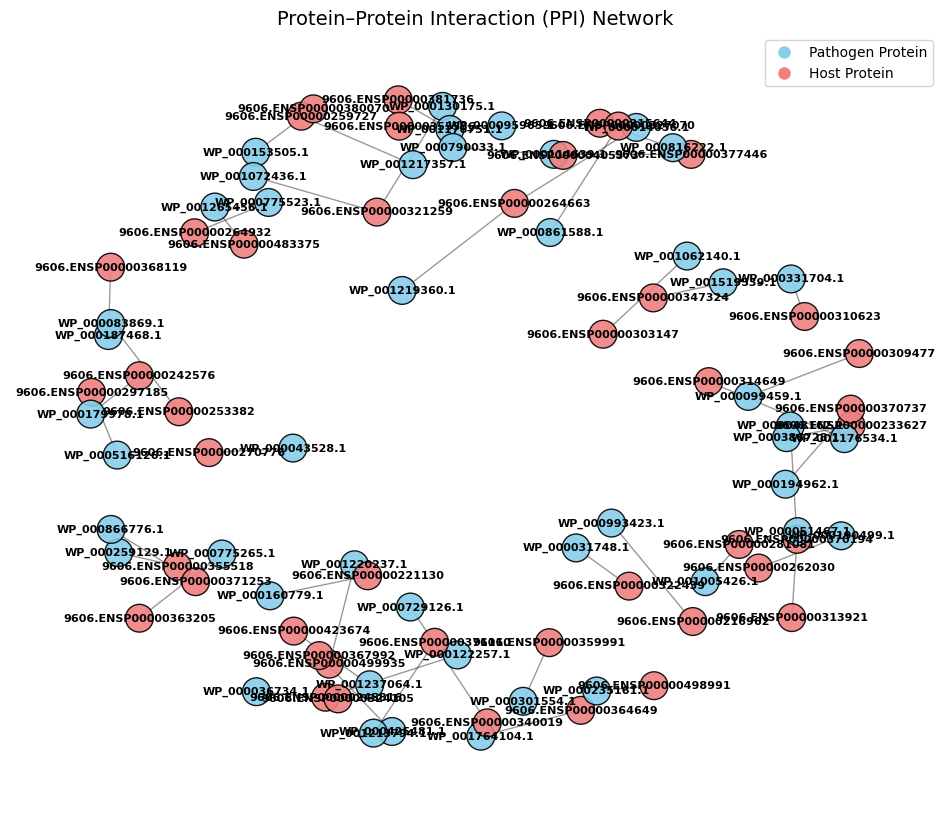


Example Node Descriptions:
WP_000130175.1: transaldolase
9606.ENSP00000321259: Transaldolase; Transaldolase is important for the balance of metabolites in the pentose-phosphate pathway.
WP_000516126.1: molecular chaperone DnaK
9606.ENSP00000297185: Stress-70 protein, mitochondrial; Chaperone protein which plays an important role in mitochondrial iron-sulfur cluster (ISC) biogenesis. Interacts with and stabilizes ISC cluster assembly proteins FXN, NFU1, NFS1 and ISCU. Regulates erythropoiesis via stabilization of ISC assembly. May play a role in the control of cell proliferation and cellular aging (By similarity). Belongs to the heat shock protein 70 family.
WP_001217357.1: GMP reductase


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Create undirected graph
G = nx.from_pandas_edgelist(
    df,
    source='queryItem',
    target='stringId',
    edge_attr=['identity', 'bitscore'],
    create_using=nx.Graph()
)

# Add node attributes
for _, row in df.iterrows():
    G.nodes[row['queryItem']]['description'] = row.get('preferredName', 'N/A')
    G.nodes[row['queryItem']]['type'] = 'pathogen'
    G.nodes[row['stringId']]['description'] = row.get('annotation', 'N/A')
    G.nodes[row['stringId']]['type'] = 'host'

# Assign colors
node_colors = [
    'skyblue' if G.nodes[n].get('type') == 'pathogen' else 'lightcoral'
    for n in G.nodes
]

# Layout and draw
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400, alpha=0.9, edgecolors='k')
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Legend
p1_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pathogen Protein', markerfacecolor='skyblue', markersize=10)
p2_patch = plt.Line2D([0], [0], marker='o', color='w', label='Host Protein', markerfacecolor='lightcoral', markersize=10)
plt.legend(handles=[p1_patch, p2_patch], loc='best')

plt.title("Protein–Protein Interaction (PPI) Network", fontsize=14)
plt.axis('off')
plt.show()

# Inspect node descriptions
print("\nExample Node Descriptions:")
for node, data in list(G.nodes(data=True))[:5]:
    print(f"{node}: {data.get('description')}")

Step 6: Interactive Visualization with PyVis

In [15]:
# ============================================================
# Step 6: Interactive Visualization with PyVis
# ============================================================
!pip install pyvis

from pyvis.network import Network
from IPython.display import display, HTML

# Initialize PyVis network
ppi_net = Network(
    height="750px",
    width="100%",
    bgcolor="#ffffff",
    directed=False,
    notebook=True,
    cdn_resources='in_line'
)

# Normalize bitscores for edge thickness
max_bitscore = df["bitscore"].max() if "bitscore" in df.columns else 1

# Function to map identity to color gradient
def identity_to_color(identity):
    try:
        val = float(identity)
    except:
        return "gray"
    r = int(255 * (1 - val / 100))
    g = int(255 * (val / 100))
    return f"rgb({r},{g},0)"

# Add nodes and edges
for _, row in df.iterrows():
    p1 = row["queryItem"]
    p2 = row["stringId"]
    identity = row.get("identity", 0)
    bitscore = row.get("bitscore", 1)
    product = row.get("preferredName", "N/A")
    annotation = row.get("annotation", "N/A")

    # Pathogen protein node
    ppi_net.add_node(
        p1,
        label=p1,
        title=f"<b>Protein:</b> {p1}<br><b>Product:</b> {product}",
        color="skyblue"
    )

    # Host protein node
    ppi_net.add_node(
        p2,
        label=p2,
        title=f"<b>Protein:</b> {p2}<br><b>Annotation:</b> {annotation}",
        color="lightcoral"
    )

    # Edge
    edge_color = identity_to_color(identity)
    edge_width = (bitscore / max_bitscore) * 10
    ppi_net.add_edge(
        p1,
        p2,
        title=f"<b>Identity:</b> {identity}%<br><b>Bitscore:</b> {bitscore}",
        color=edge_color,
        width=edge_width,
        value=float(bitscore)
    )

# Optional physics layout
ppi_net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -30000,
      "springLength": 200
    },
    "minVelocity": 0.75
  }
}
""")

# Save and render
ppi_net.save_graph("ppi_network.html")
with open("ppi_network.html", "r") as f:
    html_content = f.read()
display(HTML(html_content))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.0 MB/s eta 0:00:00


## 🔹 NetworkX Graph Construction, Visualization, and Hub Analysis

This section builds the protein–protein interaction (PPI) network from the Neo4j-extracted DataFrame using **NetworkX**.  
Key steps include:

- **Graph Construction:** Convert tabular interaction data into an undirected graph with proteins as nodes and interactions as edges.  
- **Topological Measures:** Compute degree, clustering coefficient, betweenness, and closeness centrality to assess protein importance.  
- **Network-Level Properties:** Summarize global metrics such as node/edge counts, density, and connected components.  
- **Visualization:** Generate a static network plot where node size reflects degree and color reflects betweenness centrality.  
- **Hub Identification:** Highlight the top hub proteins (highest degree) as potential biologically significant nodes for downstream enrichment or validation.

This analysis provides both a **visual overview** and **quantitative measures** of the PPI network, helping to identify critical proteins that may serve as drug targets or key regulators in host–pathogen interactions.

✅ Graph built: 90 nodes and 46 edges

📊 Network Summary:
- Nodes: 90
- Edges: 46
- Density: 0.0115
- Connected Components: 44



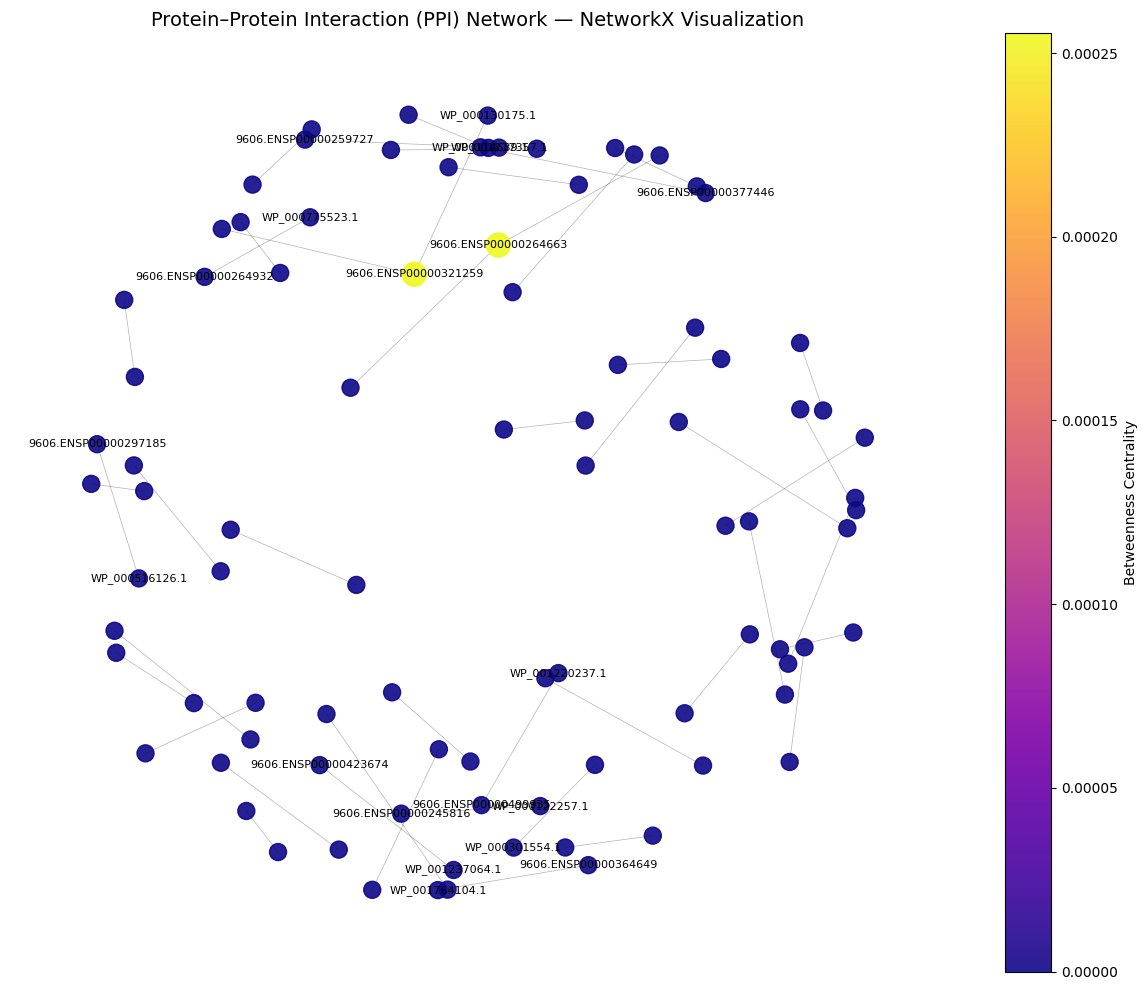

🧬 Top Hub Proteins (by number of interactions):



,Protein,Degree,Clustering,Betweenness,Closeness
1,9606.ENSP00000321259,2,0,0.000255,0.022472
27,9606.ENSP00000264663,2,0,0.000255,0.022472
2,WP_000516126.1,1,0,0.000000,0.011236
3,9606.ENSP00000297185,1,0,0.000000,0.011236
4,WP_001217357.1,1,0,0.000000,0.011236
5,9606.ENSP00000259727,1,0,0.000000,0.011236
6,WP_000122257.1,1,0,0.000000,0.011236
7,9606.ENSP00000245816,1,0,0.000000,0.011236
8,WP_001220237.1,1,0,0.000000,0.011236
0,WP_000130175.1,1,0,0.000000,0.014981


In [16]:
# ============================================================
# Step 7: Build undirected NetworkX graph
# ============================================================
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Build graph from DataFrame
G = nx.from_pandas_edgelist(
    df,
    source='queryItem',       # pathogen/query protein
    target='stringId',        # STRING partner protein
    edge_attr=['identity', 'bitscore'],
    create_using=nx.Graph()
)

print(f"✅ Graph built: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# ============================================================
# Step 8: Compute topological measures
# ============================================================
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G, weight='bitscore', normalized=True)
clustering = nx.clustering(G, weight='bitscore')
closeness = nx.closeness_centrality(G)

# Add metrics as node attributes
nx.set_node_attributes(G, degree, 'Degree')
nx.set_node_attributes(G, betweenness, 'Betweenness')
nx.set_node_attributes(G, clustering, 'Clustering')
nx.set_node_attributes(G, closeness, 'Closeness')

# ============================================================
# Step 9: Network summary statistics
# ============================================================
print(f"""
📊 Network Summary:
- Nodes: {G.number_of_nodes()}
- Edges: {G.number_of_edges()}
- Density: {nx.density(G):.4f}
- Connected Components: {nx.number_connected_components(G)}
""")

# ============================================================
# Step 10: Prepare for visualization
# ============================================================
# Layout options: spring_layout, kamada_kawai_layout, spectral_layout
pos = nx.spring_layout(G, seed=42, k=0.5)

# Node color & size mapping
node_color = [betweenness[n] for n in G.nodes()]
node_size = [degree[n] * 150 for n in G.nodes()]  # scale node size by degree

# ============================================================
# Step 11: Plot network with NetworkX
# ============================================================
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Draw nodes — colored by betweenness, sized by degree
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_size,
    node_color=node_color,
    cmap=plt.cm.plasma,
    alpha=0.9
)

# Draw labels only for top hubs
top_hubs = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:20]
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: n for n, _ in top_hubs},
    font_size=8,
    font_color='black'
)

plt.colorbar(nodes, label="Betweenness Centrality")
plt.title("Protein–Protein Interaction (PPI) Network — NetworkX Visualization", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# ============================================================
# Step 12: Identify Top Hub Proteins
# ============================================================
metrics_df = pd.DataFrame({
    "Protein": list(G.nodes()),
    "Degree": [degree[n] for n in G.nodes()],
    "Clustering": [clustering[n] for n in G.nodes()],
    "Betweenness": [betweenness[n] for n in G.nodes()],
    "Closeness": [closeness[n] for n in G.nodes()]
}).sort_values("Degree", ascending=False)

top_hubs_df = metrics_df.nlargest(20, 'Degree')
print("🧬 Top Hub Proteins (by number of interactions):\n")
display(top_hubs_df)

#------------------------------------------#

> **Note:**  
> To validate predicted host–pathogen interactions, please cross-check with the **PHISTO database**.  
> - Go to the PHISTO portal.  
> - Search for the **queried organism** (e.g., *Salmonella enterica*, *Homo sapiens*).  
> - Review the currently available **experimentally validated interactions**.  
> This step ensures that your computational predictions are supported by known biological evidence.


In [17]:
# ============================================================
# Step 13: Export Interaction Data to CSV
# ============================================================
import pandas as pd

# Ensure df contains the interaction data extracted from Neo4j
# Columns: queryItem, preferredName, stringId, annotation, identity, bitscore

# Define output filename
output_file = "PPI_interactions_export.csv"

# Save DataFrame to CSV
df.to_csv(output_file, index=False)

print(f"✅ Interaction data exported to '{output_file}'")
print("Preview of exported file:")
print(df.head(10))

✅ Interaction data exported to 'PPI_interactions_export.csv'
Preview of exported file:
        queryItem                                      preferredName  \
0  WP_000130175.1                                      transaldolase   
1  WP_000516126.1                           molecular chaperone DnaK   
2  WP_001217357.1                                      GMP reductase   
3  WP_000122257.1  ATP-dependent Clp endopeptidase proteolytic su...   
4  WP_001220237.1                                   adenylate kinase   
5  WP_001237064.1                  glucosamine-6-phosphate deaminase   
6  WP_000775523.1       succinate dehydrogenase flavoprotein subunit   
7  WP_001764104.1   succinate dehydrogenase iron-sulfur subunit SdhB   
8  WP_000114639.1                succinate--CoA ligase subunit alpha   
9  WP_000301554.1  2,3-diphosphoglycerate-dependent phosphoglycer...   

               stringId                                         annotation  \
0  9606.ENSP00000321259  Transaldolase; Tr

🧬 Functional and Pathway Enrichment Preparation
This step prepares host gene lists for downstream enrichment analysis (GO terms, KEGG pathways, Reactome, etc.).

🔹 Step 1: Extract Host Gene Symbols
- Load the merged STRING mapping file (merged_string_mapping_identity50.tsv).
- Extract unique host gene names (preferredName).
- Save gene list to host_genes_for_enrichment.txt.
- This file can be uploaded to enrichment tools such as Reactome, g:Profiler, DAVID, Enrichr, STRING enrichment.


In [18]:
# ============================================================
# Step 1: Extract Host Gene Symbols
# ============================================================
import pandas as pd

# Load merged STRING mapping file
df = pd.read_csv("merged_string_mapping_identity50.tsv", sep="\t")

# Extract unique host gene names (STRING partner proteins)
host_genes = df[['stringId', 'preferredName']].drop_duplicates()

# Build list of unique gene symbols
host_genes_list = host_genes['preferredName'].dropna().unique().tolist()

# Save gene list to file for enrichment tools
with open("host_genes_for_enrichment.txt", "w") as f:
    for gene in host_genes_list:
        f.write(gene + "\n")

print(f"✅ Prepared {len(host_genes_list)} host gene symbols for enrichment analysis saved as host_genes_for_enrichment.txt")

✅ Prepared 44 host gene symbols for enrichment analysis saved as host_genes_for_enrichment.txt


🔹 Step 2: Map ENSP IDs to UniProtKB
- Extract unique host ENSP IDs (stringId).
- Remove species prefix (e.g., 9606.ENSP... → ENSP...).
- Query UniProt REST API for UniProtKB accession and primary gene name.
- Save results to host_genes_for_enrichment_final.tsv.


In [19]:
# ============================================================
# Step 2: Map ENSP IDs to UniProtKB and Gene Names
# ============================================================
import requests
import time

# Extract unique host ENSP IDs
ensp_ids = df['stringId'].dropna().unique().tolist()

# Remove species prefix if present (e.g., 9606.ENSP00000321259 -> ENSP00000321259)
ensp_ids = [x.split('.')[-1] for x in ensp_ids]

print(f"✅ Found {len(ensp_ids)} unique ENSP IDs for mapping")

# Query UniProt REST API for gene names and UniProtKB accession
gene_mapping = []
base_url = "https://rest.uniprot.org/uniprotkb/search"

for i, ensp in enumerate(ensp_ids, 1):
    params = {
        "query": ensp,
        "fields": "accession,gene_primary",
        "format": "tsv"
    }

    try:
        r = requests.get(base_url, params=params)
        if r.status_code == 200 and r.text.strip():
            lines = r.text.strip().split('\n')
            # Skip header
            for line in lines[1:]:
                accession, gene = line.split('\t')
                gene_mapping.append({
                    'ENSP_ID': ensp,
                    'UniProtKB': accession,
                    'GeneName': gene
                })
        else:
            gene_mapping.append({'ENSP_ID': ensp, 'UniProtKB': None, 'GeneName': None})

    except Exception as e:
        gene_mapping.append({'ENSP_ID': ensp, 'UniProtKB': None, 'GeneName': None})
        print(f"⚠️ Error mapping {ensp}: {e}")

    # Avoid hammering the server
    time.sleep(0.3)

    if i % 10 == 0:
        print(f"Processed {i}/{len(ensp_ids)} ENSP IDs...")

# Save mapping to TSV file
mapping_df = pd.DataFrame(gene_mapping)
mapping_df.to_csv("host_genes_for_enrichment_final.tsv", sep='\t', index=False)

print("✅ Mapping complete. File saved as 'host_genes_for_enrichment_final.tsv'")
print(mapping_df.head())

✅ Found 44 unique ENSP IDs for mapping
Processed 10/44 ENSP IDs...
Processed 20/44 ENSP IDs...
Processed 30/44 ENSP IDs...
Processed 40/44 ENSP IDs...
✅ Mapping complete. File saved as 'host_genes_for_enrichment_final.tsv'
           ENSP_ID UniProtKB GeneName
0  ENSP00000321259    P37837   TALDO1
1  ENSP00000297185    P38646    HSPA9
2  ENSP00000259727    P36959     GMPR
3  ENSP00000245816    Q16740     CLPP
4  ENSP00000499935    P54819      AK2


In [20]:
# ============================================================
# Step 14a: Export Top 20 Host Hub Proteins with UniProt Mapping
# ============================================================
import pandas as pd

# Load UniProt mapping file (from enrichment prep step)
mapping_df = pd.read_csv("host_genes_for_enrichment_final.tsv", sep="\t")

# Normalize ENSP IDs in metrics_df (remove species prefix if present)
metrics_df["ENSP_ID"] = metrics_df["Protein"].apply(
    lambda x: x.split('.')[-1] if x.startswith("9606.") else None
)

# Filter only host proteins (those with ENSP IDs)
host_metrics = metrics_df[metrics_df["ENSP_ID"].notna()]

# Select top 20 host hubs by Degree
top_host_hubs = host_metrics.nlargest(20, "Degree")

# Merge with UniProt mapping
host_hubs_annotated = top_host_hubs.merge(
    mapping_df,
    on="ENSP_ID",
    how="left"
)

# Save to CSV
host_hubs_annotated.to_csv("Top20_Host_Hubs_Annotated.csv", index=False)

print("✅ Exported Top 20 Host Hub Proteins with UniProt IDs and Gene Names")
print("File saved as 'Top20_Host_Hubs_Annotated.csv'")

# Preview
print("\n🧬 Top 20 Host Hub Proteins (with UniProt IDs and Gene Names):")
print(host_hubs_annotated.head())

✅ Exported Top 20 Host Hub Proteins with UniProt IDs and Gene Names
File saved as 'Top20_Host_Hubs_Annotated.csv'

🧬 Top 20 Host Hub Proteins (with UniProt IDs and Gene Names):
                Protein  Degree  Clustering  Betweenness  Closeness  \
0  9606.ENSP00000321259       2           0     0.000255   0.022472   
1  9606.ENSP00000264663       2           0     0.000255   0.022472   
2  9606.ENSP00000297185       1           0     0.000000   0.011236   
3  9606.ENSP00000259727       1           0     0.000000   0.011236   
4  9606.ENSP00000245816       1           0     0.000000   0.011236   

           ENSP_ID UniProtKB GeneName  
0  ENSP00000321259    P37837   TALDO1  
1  ENSP00000264663    Q13423      NNT  
2  ENSP00000297185    P38646    HSPA9  
3  ENSP00000259727    P36959     GMPR  
4  ENSP00000245816    Q16740     CLPP  
